<a href="https://colab.research.google.com/github/patricknzk/GANs-PyTorch/blob/main/GANs_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Adversarial Networks

Welcome to my notebook. Here I will explore General Adversarial Networks, code prepared for my report (...).

##  Part 1: Simple Implementation of GANs

In [ ]:
import numpy as np
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

### Step 1: Generate a simple data distribution

We will define two functions, our function y(x) we want to recreate, and x inputs.

In [ ]:
# Generate sine function
def generate_y(x):
    return math.sin(x)

# Generate sample x data
def sample_data(n=256, scale=8):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = generate_y(x[i])
        data.append([x[i], yi])

    return torch.tensor(data).float()

Let's view what we are trying to recreate.


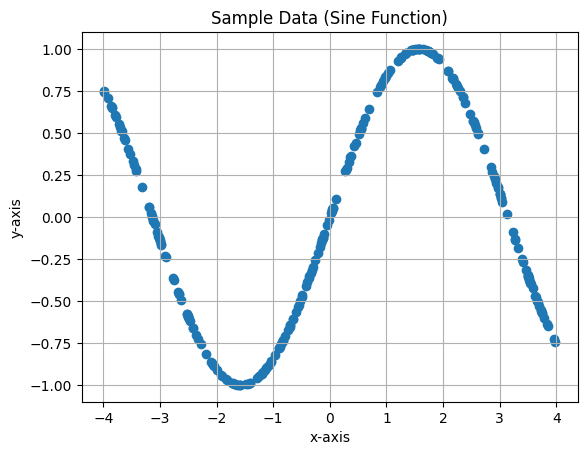

In [ ]:
# Plot sample data
data = sample_data()
plt.scatter(data[:,0], data[:,1])
plt.title('Sample Data (Sine Function)')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.grid(True)
plt.show()

Looks good!

### Step 2: Intialise generator and discriminator networks

First we write up the code for the Generator and Discriminator function.

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, size = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
        )

    def forward(self, Z):
        return self.net(Z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, size = 128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
        )
        self.logit = nn.Sequential(
            nn.Linear(2, 1)
        )

    def forward(self, X):
        out = self.net(X)
        logit = self.logit(out)
        return logit, out

Initialise the two models and use the systems GPU for training.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialise
G = Generator().to(device)
D = Discriminator().to(device)

Define our loss function (Binary Cross Entropy) and our optimiser (ADAM)

In [ ]:
# Loss functions & Optimiser functions
loss_fn = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

### Step 3: Train models

Define the step function.

1. Train discriminator with fake and real data. Challenge the discriminator to distinguish between the two. Intialise loss as the sum of the loss of the real and fake data.

2. Train genereator function with random variables and calculate the loss by comparing the generated data and real data.

In [ ]:
def train_step(x_real):
    G.train()
    D.train()
    bs = x_real.size(0)
    x_real = x_real.to(device)

    # Train discriminator
    z = torch.randn(bs, 2, device = device)
    with torch.no_grad():
      x_fake = G(z)

    d_opt.zero_grad()
    d_real_logit, _ = D(x_real)
    d_fake_logit, _ = D(x_fake)

    real_targets = torch.ones_like(d_real_logit)
    fake_targets = torch.zeros_like(d_fake_logit)

    d_loss = loss_fn(d_real_logit, real_targets) + loss_fn(d_fake_logit, fake_targets)
    d_loss.backward()
    d_opt.step()

    # Train generator
    z = torch.randn(bs, 2, device = device)
    g_opt.zero_grad()
    x_fake = G(z)
    d_fake_logit, _ = D(x_fake)
    g_loss = loss_fn(d_fake_logit, real_targets) # Generator wants fake data to be classified as real
    g_loss.backward()
    g_opt.step()

    return d_loss.item(), g_loss.item()

Store the loss values and train the models.

In [ ]:
d_losses = []
g_losses = []
for epoch in range(10000):
  d_loss, g_loss = train_step(data)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
        print(f"epoch {epoch}: D {d_loss:.3f} | G {g_loss:.3f}")

epoch 0: D 1.484 | G 1.045
epoch 100: D 1.315 | G 0.982
epoch 200: D 1.081 | G 1.016
epoch 300: D 1.416 | G 0.651
epoch 400: D 1.331 | G 0.836
epoch 500: D 1.463 | G 0.782
epoch 600: D 1.397 | G 0.878
epoch 700: D 1.389 | G 0.855
epoch 800: D 1.355 | G 0.792
epoch 900: D 1.377 | G 0.717
epoch 1000: D 1.348 | G 0.707
epoch 1100: D 1.355 | G 0.707
epoch 1200: D 1.332 | G 0.740
epoch 1300: D 1.344 | G 0.701
epoch 1400: D 1.345 | G 0.697
epoch 1500: D 1.336 | G 0.767
epoch 1600: D 1.369 | G 0.696
epoch 1700: D 1.371 | G 0.721
epoch 1800: D 1.377 | G 0.706
epoch 1900: D 1.374 | G 0.709
epoch 2000: D 1.374 | G 0.714
epoch 2100: D 1.368 | G 0.701
epoch 2200: D 1.377 | G 0.708
epoch 2300: D 1.375 | G 0.700
epoch 2400: D 1.374 | G 0.699
epoch 2500: D 1.373 | G 0.698
epoch 2600: D 1.375 | G 0.703
epoch 2700: D 1.376 | G 0.698
epoch 2800: D 1.379 | G 0.693
epoch 2900: D 1.379 | G 0.697
epoch 3000: D 1.382 | G 0.701
epoch 3100: D 1.384 | G 0.694
epoch 3200: D 1.386 | G 0.697
epoch 3300: D 1.383 | 

View the loss curve.

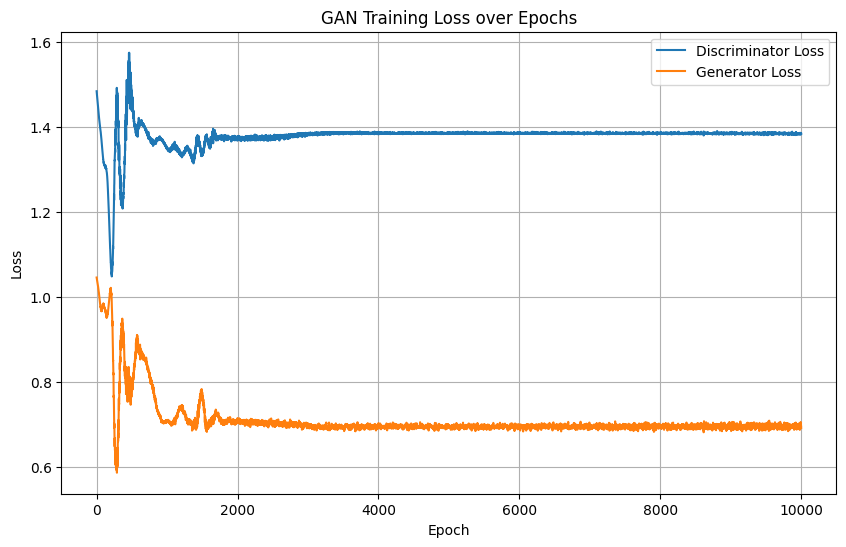

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Analysis

Compare real and generated sine function.

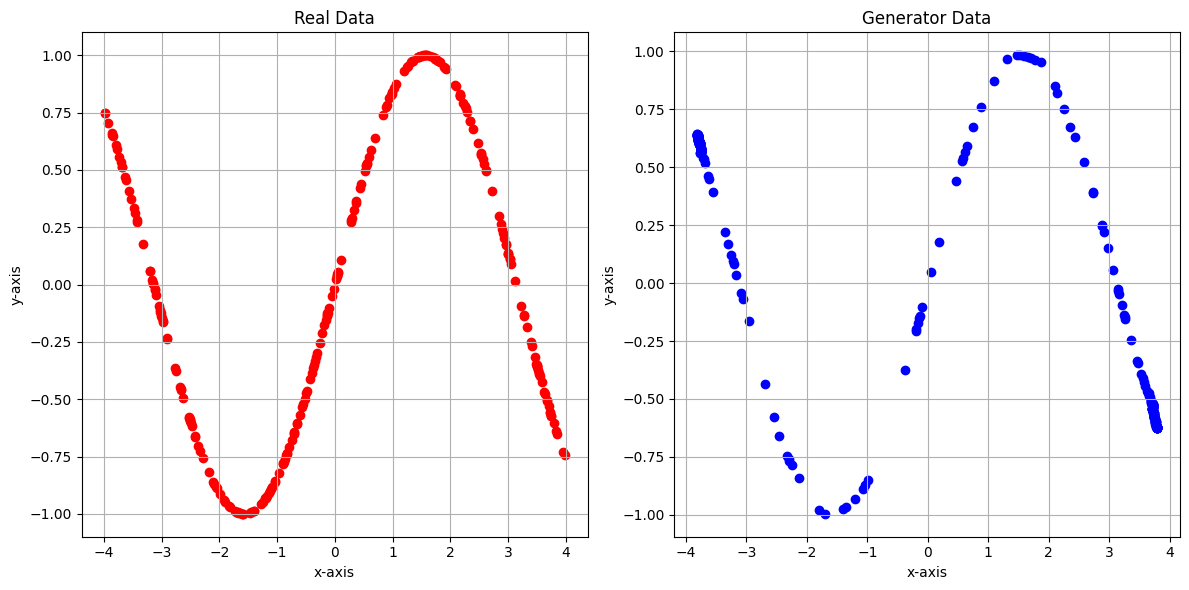

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c='r')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Real Data')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(G(data).detach().numpy()[:,0], G(data).detach().numpy()[:,1], c='b')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Generator Data')
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 2: Application - Data Augmentation

We will extend our simple model to accomodate a numerical dataset. The purpose is to test the limit of GANs in producing additional data.

### Step 1: Load dataset

Load our dataset and a sepearte dataset for scaling.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Load data
dataset = pd.read_csv('StressLevelDataset.csv')
dataset = dataset[['depression', 'anxiety_level']]
scaled_data = dataset

Scale the data, intialise a training split using only 20 data points. Initialise data tensor for training models.

In [ ]:
# Scale the data
scaler = MinMaxScaler()
scaled_data[['depression', 'anxiety_level']] = scaler.fit_transform(scaled_data[['depression', 'anxiety_level']])

# Scaled train split
X_train, X_test, y_train, y_test = train_test_split(scaled_data.depression, scaled_data.anxiety_level, test_size=0.2, random_state=42)
X_train_xs1, X_train_xs2, y_train_xs1, y_train_xs2 = train_test_split(X_train, y_train, train_size=20, random_state=42) # small data set (20) to imitate limitations

# Create training data tensor for input
data_xs1 = torch.tensor([X_train_xs1.values, y_train_xs1.values]).float().T

/tmp/ipython-input-3543996747.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  data_xs1 = torch.tensor([X_train_xs1.values, y_train_xs1.values]).float().T


View the target data.

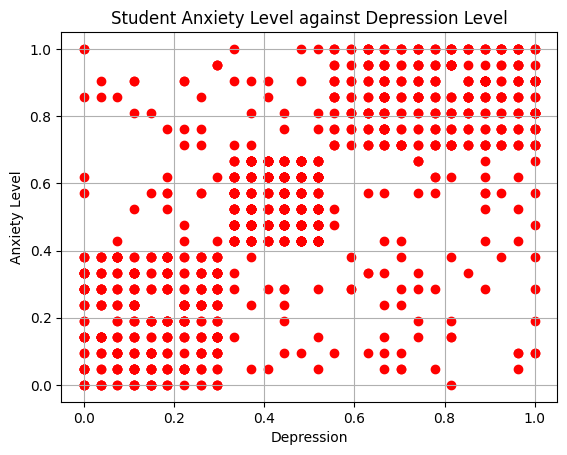

In [ ]:
# View data
plt.scatter(dataset.depression, dataset.anxiety_level, c='r')
plt.xlabel('Depression')
plt.ylabel('Anxiety Level')
plt.title('Student Anxiety Level against Depression Level')
plt.grid(True)
plt.show()

### Step 2: Build & Train GANs

Similar to part 1, we create our generator and discriminator functions. Changed size from 128 to 64 since it improves performance.

We initialise the two classes, loss functions and optimisers all in the same cell.

In [ ]:
# Generator
class Generator(nn.Module):
    def __init__(self, size = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
        )

    def forward(self, Z):
        return self.net(Z)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, size = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
        )
        self.logit = nn.Sequential(
            nn.Linear(2, 1)
        )

    def forward(self, X):
        out = self.net(X)
        logit = self.logit(out)
        return logit, out

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialise classes
G = Generator().to(device)
D = Discriminator().to(device)

# Loss function + optimisers
loss_fn = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Step 3: Train Models

Train models.

In [ ]:
d_losses = []
g_losses = []

for epoch in range(3500):
  d_loss, g_loss = train_step(data_xs1)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
        print(f"epoch {epoch}: D {d_loss:.3f} | G {g_loss:.3f}")

epoch 0: D 1.423 | G 1.008
epoch 100: D 1.432 | G 0.752
epoch 200: D 1.417 | G 0.662
epoch 300: D 1.393 | G 0.673
epoch 400: D 1.391 | G 0.668
epoch 500: D 1.377 | G 0.754
epoch 600: D 1.383 | G 0.678
epoch 700: D 1.397 | G 0.669
epoch 800: D 1.364 | G 0.757
epoch 900: D 1.415 | G 0.685
epoch 1000: D 1.364 | G 0.689
epoch 1100: D 1.385 | G 0.701
epoch 1200: D 1.383 | G 0.717
epoch 1300: D 1.384 | G 0.690
epoch 1400: D 1.381 | G 0.685
epoch 1500: D 1.395 | G 0.710
epoch 1600: D 1.385 | G 0.704
epoch 1700: D 1.385 | G 0.696
epoch 1800: D 1.385 | G 0.694
epoch 1900: D 1.381 | G 0.684
epoch 2000: D 1.384 | G 0.689
epoch 2100: D 1.385 | G 0.698
epoch 2200: D 1.389 | G 0.680
epoch 2300: D 1.381 | G 0.691
epoch 2400: D 1.381 | G 0.697
epoch 2500: D 1.382 | G 0.705
epoch 2600: D 1.382 | G 0.702
epoch 2700: D 1.381 | G 0.700
epoch 2800: D 1.383 | G 0.692
epoch 2900: D 1.381 | G 0.699
epoch 3000: D 1.381 | G 0.696
epoch 3100: D 1.384 | G 0.693
epoch 3200: D 1.386 | G 0.692
epoch 3300: D 1.382 | 

View loss curves.

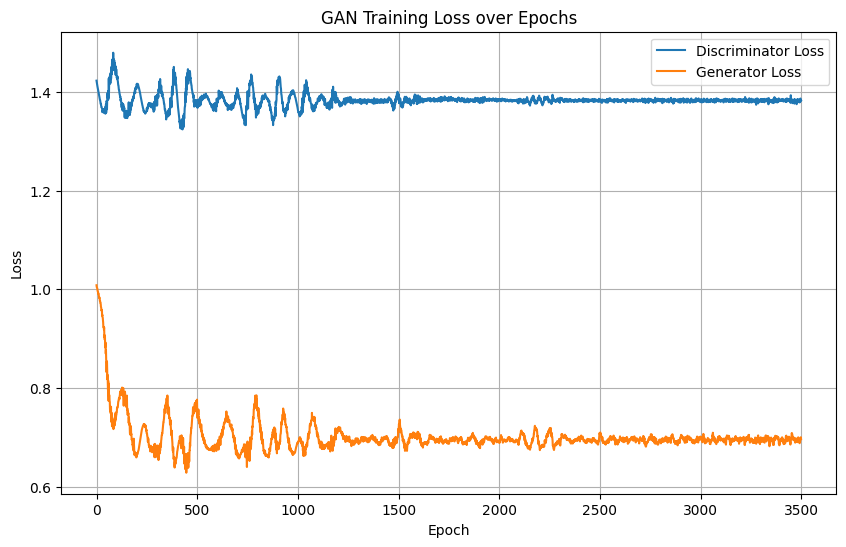

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Generate synthetic data

Generate number of data points proportional to data points left in the test set.

In [ ]:
num_samples = len(X_train_xs2) # how many synthetic datapoints?
z = torch.randn(num_samples, 2, device=device)
synthetic_data_tensor = G(z)
synthetic_data = synthetic_data_tensor.detach().cpu().numpy()
synthetic_data_tensor.size()

torch.Size([860, 2])

### Step 5: View real and synthetic data

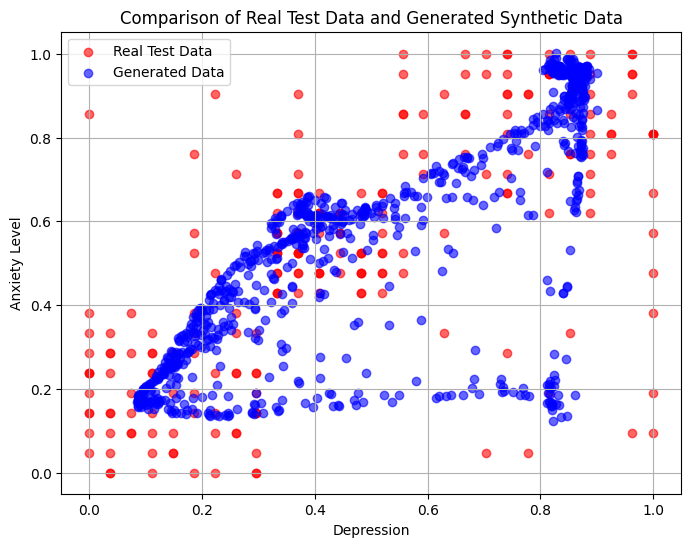

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, c='r', label='Real Test Data', alpha=0.6)
plt.scatter(synthetic_data[:, 0], synthetic_data[:, 1], c='b', label='Generated Data', alpha=0.6)
plt.xlabel('Depression')
plt.ylabel('Anxiety Level')
plt.title('Comparison of Real Test Data and Generated Synthetic Data')
plt.legend()
plt.grid(True)
plt.show()

### Step 6: Process & clean data

Match the data format in the target data.

In [ ]:
# Match dataframe
df_synth = pd.DataFrame(synthetic_data)
df_synth.columns = ['depression', 'anxiety_level']

# Unscale generated data
df_synth[['depression', 'anxiety_level']] = scaler.inverse_transform(df_synth[['depression', 'anxiety_level']])

# Augment to match data
df_synth = df_synth.astype(int)
df_synth = df_synth[((df_synth['depression'] <= 27) & (df_synth['anxiety_level'] <= 21))]

# Redefine dataset (scaling bug)
dataset = pd.read_csv('StressLevelDataset.csv')
dataset = dataset[['depression', 'anxiety_level']]

# Redefine test split using unscaled data
X_train, X_test, y_train, y_test = train_test_split(dataset.depression, dataset.anxiety_level, test_size=0.2, random_state=42)

View real and generated data.

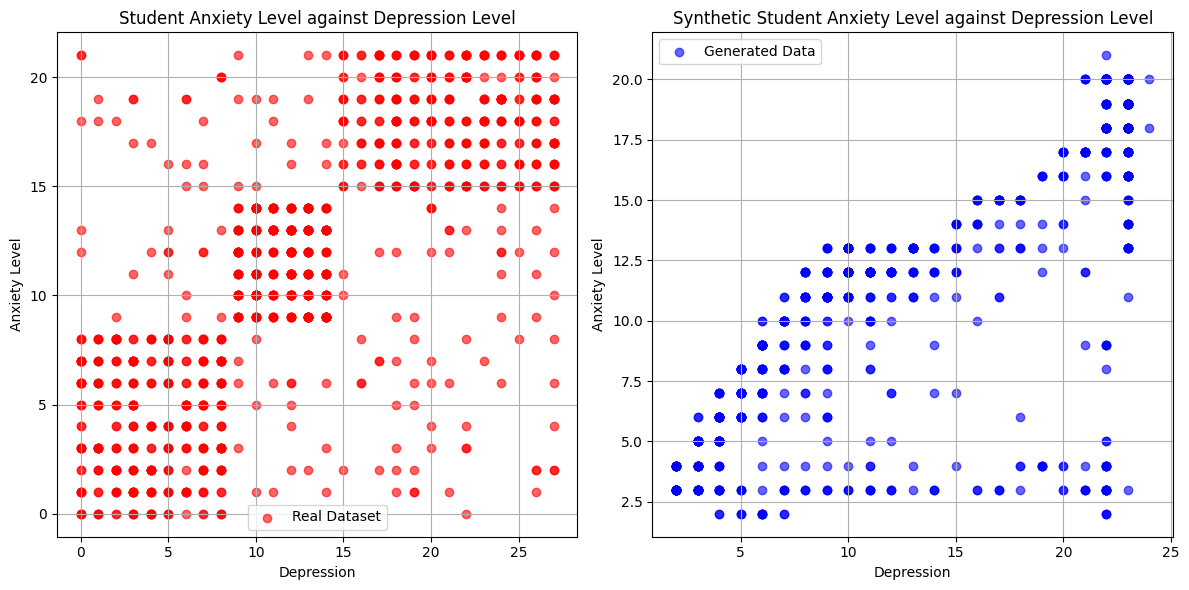

In [ ]:
plt.figure(figsize=(12, 6))

# Plot real dataset
plt.subplot(1, 2, 1)
plt.scatter(dataset.depression, dataset.anxiety_level, c='r', label='Real Dataset', alpha=0.6)
plt.xlabel('Depression')
plt.ylabel('Anxiety Level')
plt.title('Student Anxiety Level against Depression Level')
plt.grid(True)
plt.legend()

# Plot generated data
plt.subplot(1, 2, 2) # 1 row, 2 columns, 2nd plot
plt.scatter(df_synth.depression, df_synth.anxiety_level, c='b', label='Generated Data', alpha=0.6)
plt.xlabel('Depression')
plt.ylabel('Anxiety Level')
plt.title('Synthetic Student Anxiety Level against Depression Level')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Step 7: Data performance comparison

Fit a linear model onto the synthetic data.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare real test data for evaluation
X_test_real = X_test.values.reshape(-1, 1)
y_test_real = y_test.values.reshape(-1, 1)

# REGRESSION MODEL (SYNTHETIC DATA)
# Split synth data
X_train_synth = df_synth.depression.values.reshape(-1, 1)
y_train_synth = df_synth.anxiety_level.values.reshape(-1, 1)

# Train a Regression model on synthetic data
model_synth = LinearRegression()
model_synth.fit(X_train_synth, y_train_synth)

# Synthetic y predictions
y_pred_synth = model_synth.predict(X_test_real)

# Evaluate the model trained on synthetic data
mse_synth = mean_squared_error(y_test_real, y_pred_synth)
r2_synth = r2_score(y_test_real, y_pred_synth)

print(f"Model trained on Synthetic Data:")
print(f"Mean Squared Error: {mse_synth:.2f}")
print(f"R-squared: {r2_synth:.2f}")

Model trained on Synthetic Data:
Mean Squared Error: 21.30
R-squared: 0.43


Fit a linear model onto the real data.

In [ ]:
# REGRESSION MODEL (REAL DATA)
# Split real data
X_train_real = dataset.depression.values.reshape(-1, 1)
y_train_real = dataset.anxiety_level.values.reshape(-1, 1)

# Train regression model on real data
model_real = LinearRegression()
model_real.fit(X_train_real, y_train_real)

# Real y predictions
y_pred_real = model_real.predict(X_test_real)

# Evaluate the model trained on real data
mse_real = mean_squared_error(y_test_real, y_pred_real)
r2_real = r2_score(y_test_real, y_pred_real)

print(f"Model trained on Real Data:")
print(f"Mean Squared Error: {mse_real:.2f}")
print(f"R-squared: {r2_real:.2f}")

Model trained on Real Data:
Mean Squared Error: 20.91
R-squared: 0.44


Compare the fit of the two models.

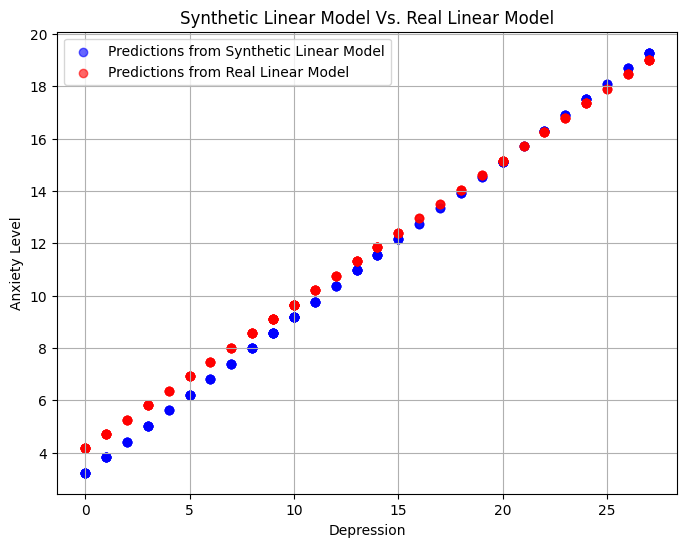

In [ ]:
# Compare linear models
plt.figure(figsize=(8, 6))
plt.scatter(X_test_real, y_pred_synth, c='b', label='Predictions from Synthetic Linear Model', alpha=0.6)
plt.scatter(X_test_real, y_pred_real, c='r', label='Predictions from Real Linear Model', alpha=0.6)
plt.xlabel('Depression')
plt.ylabel('Anxiety Level')
plt.title('Synthetic Linear Model Vs. Real Linear Model')
plt.legend()
plt.grid(True)
plt.show()